## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for alpha / beta (intercept / slope) linear fit to general market movement

In [1]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [94]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
max_investment = 1180*0.2
min_investment = 15

In [95]:
%matplotlib inline
## Installing Required Packages
import sys
import time
import math
import pickle
import alpaca_trade_api as tradeapi
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Pulling API Keys
Keys = pd.read_csv(os.path.join('..','Data','Keys','Live API.txt'))

## Connecting to Alpaca
api = tradeapi.REST(Keys['Key ID'][0],Keys['Secret Key'][0], api_version='v2')

## API Initial Set Up
### Get Current Account Information
account = api.get_account()

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [96]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets if i._raw['tradable'] & i._raw['shortable']  & i._raw['easy_to_borrow']]

## Grabbing Most Recent Polyon Data
Snapshot = api.polygon.all_tickers()

## Filtering Based On Price And Volume Criteria
Stocks = []
for i in Snapshot:
    if i.day['c'] < max_investment \
    and i.day['c'] > min_investment \
    and i.ticker in Final_Assets \
    and i.day['v'] > min_volume:
        Stocks.append(i.ticker)

## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in range(1,len(Splits)):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

## Pulling Historical Data
counter = 0
for i in tqdm(Final_Stocks):
    TMP = api.polygon.historic_agg_v2(i, 1, 'day', _from=start_date.strftime("%Y-%m-%d"), to=datetime.now().strftime("%Y-%m-%d")).df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

### Exploring Total Market Performance

In [97]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(5)

,close,high,low,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,
2020-10-02 00:00:00-04:00,64.000447,64.743950,62.280229,3.621789e+06,1007.0,0.003850,0.030688,-0.047981,63.428620,40.683897,0.103755
2020-10-05 00:00:00-04:00,65.272354,65.752683,64.030586,3.604034e+06,1007.0,0.019873,0.031433,-0.004902,63.826458,35.893440,0.223560
2020-10-06 00:00:00-04:00,64.806806,66.561901,64.330361,4.038576e+06,1007.0,-0.007132,0.030589,0.120571,64.211160,41.565205,0.258515
2020-10-07 00:00:00-04:00,65.948059,66.626316,64.941195,3.622975e+06,1007.0,0.017610,0.043132,-0.102908,64.756532,44.976817,0.340409
2020-10-08 00:00:00-04:00,66.688664,67.333040,65.677108,3.561830e+06,1007.0,0.011230,0.046015,-0.016877,65.343266,44.669053,0.421085


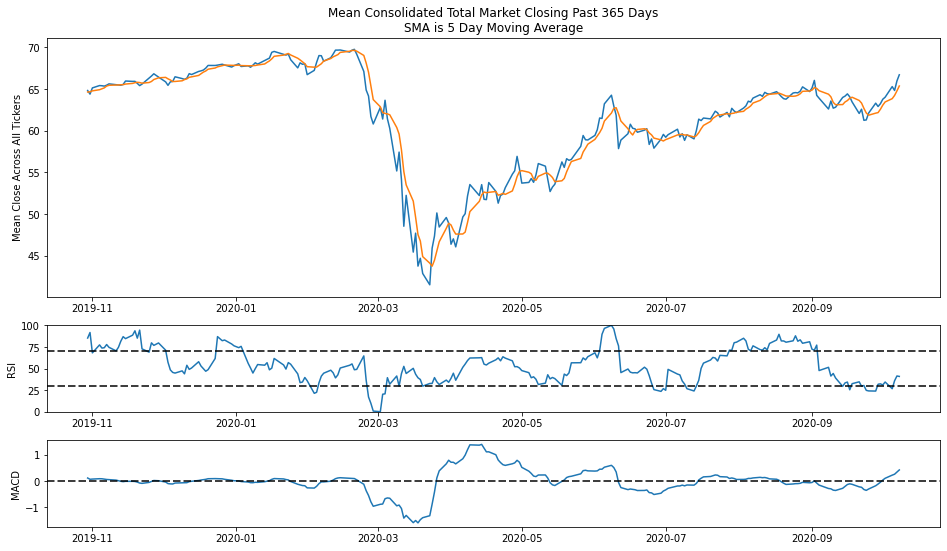

In [98]:
Plot_Data = Total_Market
Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100


Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(ylabel = "MACD",
      xlabel = "")
fig.set_size_inches(16,9)

## Digging Into A Sector Ranking

In [99]:
Sectors = list(Combined_Data['sector'].unique())
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_alpha = 0,
                                    min_macd = 0,
                                    max_rsi = 70
)
Sector_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
sector,,,,,,,,,,,,,
Utilities,46,0.049092,57.611235,63.044852,54.894426,58.899087,0.833549,0.006871,44.790986,0.459838,0.009252,0.010,0.066557
Real Estate,77,0.046243,57.769283,62.580068,55.363890,59.425675,1.069373,0.003571,38.764765,0.290383,0.004641,0.588,0.694590
Financial Services,132,0.047545,56.841332,62.866092,53.828953,58.442644,0.822905,0.003753,49.536849,0.304488,0.002131,0.504,1.023417
Consumer Cyclical,156,0.046100,55.775341,61.808377,52.758823,57.600744,0.757391,0.004568,51.874393,0.206303,0.000323,0.832,1.233276
Industrials,145,0.034621,75.995684,83.857971,72.064540,78.330559,0.705758,0.002802,32.355788,0.214619,0.000035,0.728,0.948135


## Diving Further Into Individual Idustries

In [104]:
Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
Industries = list(Top_Sector['industry'].unique())
Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                      groups = Industries,
                                      column = 'industry',
                                      min_alpha = 0,
                                      min_macd = 0,
                                      max_rsi = 70
                                     )
Industry_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
industry,,,,,,,,,,,,,
Utilities - Independent Power Producers,4,0.070165,51.635517,59.479483,47.713535,53.219000,1.807024,0.011749,57.684779,0.675292,0.010277,0.092,0.421077
Autos,25,0.096846,55.605110,65.273290,50.771020,58.801680,0.915454,0.007846,57.317250,0.560702,0.010027,0.076,1.244245
Utilities - Regulated,42,0.047329,58.180351,63.384411,55.578321,59.440048,0.648169,0.006467,51.617576,0.439318,0.009170,0.022,0.036679
Advertising & Marketing Services,2,0.053641,33.812205,37.677795,31.879410,34.843000,0.874247,0.002340,31.174177,0.159551,0.006276,0.580,0.610602
Engineering & Construction,10,0.066470,43.311293,50.370707,39.781586,45.167400,0.697740,0.006663,50.301322,0.239237,0.005514,0.512,1.049354
Employment Services,4,0.051792,55.804000,62.911000,52.250500,57.846000,0.939669,0.004965,50.812824,0.394895,0.005272,0.550,0.666866
Banks,44,0.064999,43.277965,49.023853,40.405020,44.899727,0.780064,0.003750,42.907114,0.291318,0.005182,0.412,1.088285
REITs,71,0.044809,56.963854,61.593893,54.648835,58.532155,0.972760,0.003373,38.863741,0.286524,0.004731,0.586,0.649046
Consulting & Outsourcing,11,0.080566,51.399610,59.482208,47.358312,54.137273,0.817519,0.005005,44.983404,0.352164,0.004663,0.544,1.560410


## Diving Into The Individual Stocks

In [105]:
Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
Stocks = list(Top_Industry['stock'].unique())
Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                   groups = Stocks,
                                   column = 'stock',
                                   min_alpha = 0,
                                   max_alpha_p = 0.20,
                                   min_macd = 0,
                                   max_rsi = 50,
                                   min_risk_ratio = 1
)
Stock_Summary. \
    sort_values(by = ['rsi'],ascending = [1])

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
stock,,,,,,,,,,,,,
LAZ,1,0.080079,34.25408,38.50592,32.12816,34.956,1.039460,0.003903,37.840405,0.154265,0.015053,0.178,0.050502
OGE,1,0.076682,30.74386,34.73614,28.74772,32.050,1.311884,0.009140,42.608291,0.375973,0.012878,0.130,0.350550


In [106]:
Stocks = ['NGG','ES','PPL','FRC']
Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock]

mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix


ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.20),
    verbose = False
)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

OrderedDict([('LAZ', 0.2), ('OGE', 0.0), ('FRC', 0.2), ('NGG', 0.2), ('ES', 0.2), ('PPL', 0.2)])
Expected annual return: 10.7%
Annual volatility: 38.7%
Sharpe Ratio: 0.23
